In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from langchain.globals import set_verbose, set_debug

set_debug(False)
set_verbose(False)

In [3]:
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.vectorstores import Chroma
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.retrievers.document_compressors import LLMChainFilter
from langchain.retrievers import ContextualCompressionRetriever
from langchain_core.messages import AIMessage, HumanMessage

In [4]:
from dotenv import load_dotenv
import os
from tqdm import tqdm

# Common data processing
import textwrap

# Langchain
from langchain_community.graphs import Neo4jGraph
from langchain_community.vectorstores import Neo4jVector
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQAWithSourcesChain, RetrievalQA
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain.chains import GraphCypherQAChain

In [5]:
# llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [6]:
# Load from environment
load_dotenv('.env', override=True)
NEO4J_URI = "bolt://localhost:7687"
NEO4J_USERNAME = "neo4j"
NEO4J_PASSWORD = "Pouria.1378"
NEO4J_DATABASE = os.getenv('NEO4J_DATABASE') or 'neo4j'
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

# Global constants
KEYWORD_INDEX_NAME = 'keyword'
VECTOR_INDEX_NAME = 'paper_chunks_vec'
VECTOR_NODE_LABEL = 'Chunk'
VECTOR_SOURCE_PROPERTY = 'text'
VECTOR_EMBEDDING_PROPERTY = 'textEmbedding'

In [184]:
kg = Neo4jGraph(
    url=NEO4J_URI, username=NEO4J_USERNAME, password=NEO4J_PASSWORD, database=NEO4J_DATABASE
)

In [185]:
persist_directory = 'all_docs_zotero/chroma/'
embedding = OpenAIEmbeddings()

vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding)

metadata_field_info = [
    AttributeInfo(
        name="Publication Year",
        description="The year that the paper was published.",
        type="integer",
    ),
    AttributeInfo(
        name="Date Added",
        description="The year that the paper was added to the collection.",
        type="integer",
    ),
    AttributeInfo(
        name="Author",
        description="Authors of the paper, it could be couple of people.",
        type="string",
    ),
    AttributeInfo(
        name="Title", 
        description="Title of the paper that the paper is about.", 
        type="string",
    ),
]

document_content_description = "Brain Heart Interconnectome (BHI) research papers"

retriever = SelfQueryRetriever.from_llm(
    llm,
    vectordb,
    document_content_description,
    metadata_field_info,
    #search_kwargs={"k": 10}
    #enable_limit=True,
)

_filter = LLMChainFilter.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=_filter,
    base_retriever=retriever
)

In [186]:
### Contextualize question ###
contextualize_q_system_prompt = """Given a chat history and the latest user question \
which might reference context in the chat history, formulate a standalone question \
which can be understood without the chat history. Do NOT answer the question, \
just reformulate it if needed and otherwise return it as is."""

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

### Answer question ###
qa_system_prompt = """You are an assistant for question-answering tasks. \
Use the following pieces of retrieved context to answer the question. \
If you don't know the answer, just say that you don't know.

{context}"""

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", qa_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

### Statefully manage chat history ###
store = {}


def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]

In [187]:
history_aware_retriever = create_history_aware_retriever(
    llm, compression_retriever, contextualize_q_prompt
)

question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

conversational_rag_chain = RunnableWithMessageHistory(
    rag_chain,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer",
)

In [188]:
retrieval_query_window = """
MATCH window=
    (:Chunk)-[:NEXT*0..1]->(node)-[:NEXT*0..1]->(:Chunk)
WITH node, score, window as longestWindow 
  ORDER BY length(window) DESC LIMIT 3
WITH nodes(longestWindow) as chunkList, node, score
  UNWIND chunkList as chunkRows
WITH collect(chunkRows.text) as textList, node, score
RETURN apoc.text.join(textList, " \n ") as text,
    score,
    node {.authors, .date_added, .page, .publication_year, .title} AS metadata
"""

vector_store_window = Neo4jVector.from_existing_index(
    embedding=OpenAIEmbeddings(),
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    database="neo4j",
    index_name=VECTOR_INDEX_NAME,
    keyword_index_name=KEYWORD_INDEX_NAME,
    search_type='hybrid',
    text_node_property=VECTOR_SOURCE_PROPERTY,
    retrieval_query=retrieval_query_window,
)

retriever_window = vector_store_window.as_retriever()

history_aware_graph_retriever = create_history_aware_retriever(
    llm, retriever_window, contextualize_q_prompt
)

question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

rag_chain_for_graph = create_retrieval_chain(history_aware_graph_retriever, question_answer_chain)

graph_rag_chain = RunnableWithMessageHistory(
    rag_chain_for_graph,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer",
)

In [189]:
CYPHER_GENERATION_TEMPLATE = """Task:Generate Cypher statement to query a graph database.
Instructions:
Use only the provided relationship types and properties in the schema.
Do not use any other relationship types or properties that are not provided.
Schema:
{schema}
Note: Do not include any explanations or apologies in your responses.
Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.
Do not include any text except the generated Cypher statement.
Examples: Here are a few examples of generated Cypher statements for particular questions:

# Find all chunks containing the word 'consort'.
MATCH (c:Chunk)
    WHERE c.text CONTAINS 'consort'
RETURN c.text

# Retrieve chunks and their titles that contain a specific keyword.
MATCH (c:Chunk)-[:BELONGS_TO]->(t:Title)
    WHERE c.text CONTAINS 'specific keyword'
RETURN t.name, c.text


# How many papers published in 2021?
MATCH (t:Title)-[:PUBLISHED_IN]->(y:Year)
    WHERE y.value = 2021
RETURN COUNT(t)

# What papers did a specific author write?
MATCH (a:Author)-[:WROTE]->(t:Title)
    WHERE a.name = 'Author Name'
RETURN t.name

# Which papers were published in a specific year?
MATCH (t:Title)-[:PUBLISHED_IN]->(y:Year {{value: 2021}})
RETURN t.name

# Retrieve all chunks belonging to a specific paper.
MATCH (t:Title {{name: 'Paper Title'}})<-[:BELONGS_TO]-(c:Chunk)
RETURN c.text

# List all authors who wrote papers in a given year.
MATCH (a:Author)-[:WROTE]->(t:Title)-[:PUBLISHED_IN]->(y:Year {{value: 2022}})
RETURN a.name

The question is:
{question}"""

CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["schema", "question"], 
    template=CYPHER_GENERATION_TEMPLATE
)

cypherChain = GraphCypherQAChain.from_llm(
    ChatOpenAI(temperature=0),
    graph=kg,
    verbose=True,
    return_intermediate_steps=True,
    output_key="answer",
    cypher_prompt=CYPHER_GENERATION_PROMPT,
)

In [190]:
#

In [191]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolInvocation
from langgraph.prebuilt import ToolExecutor
from langchain_core.prompts import PromptTemplate
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from langchain_core.output_parsers import StrOutputParser
from langchain_community.utilities import SQLDatabase
from langchain.chains import create_sql_query_chain
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter


@tool("rag")
def rag_tool(query: str, session_id: str):
    """Returns the answer to the question with searching for information from the vectorstore."""
    
    out = conversational_rag_chain.invoke({"input": query}, 
                                          config={
                                              "configurable": {"session_id": session_id}
                                          },
    )
    
    return out


@tool("sql")
def sql_tool(query: str, session_id: str):
    """Returns the answer to the questions which is transformable to a sql query."""
    
    db = SQLDatabase.from_uri("sqlite:///C:/Users/pouri/Python/Lang_Chain/Projects/BHI_project/all_docs_zotero/chroma/chroma_new.sqlite3", include_tables=['embedding_metadata'])
    
    execute_query = QuerySQLDataBaseTool(db=db)
    
    seed_prompt = """
    Given an input question, create a syntactically correct MySQL SQL query to run.

    Question: "Question here"
    SQLQuery: "SQL Query to run"

    """
    restrictions = """
    Format all numeric response ###,###,###,###.
    Only return relevant columns to the question.
    If a table or column does not exist, return table or column could not be found.
    Only type the SQL query and do not write ```sql before the SQL query statement.
    Question: {input}
    Top_k: {top_k}
    Table Info: {table_info}
    """
    prompt = seed_prompt + restrictions
    PROMPT = PromptTemplate(
        input_variables=["input", "top_k", "table_info"], template=prompt
    )

    write_query = create_sql_query_chain(llm, db, prompt=PROMPT)
    
    query = " ".join(query.split("session_id")[:-1])[:-4]
    
    answer_prompt = PromptTemplate.from_template(
    """Given the following user question, corresponding SQL query, 
    and SQL result, answer the user question.

    Question: {question}
    SQL Query: {query}
    SQL Result: {result}
    Answer: """
    )
    
    answer = answer_prompt | llm | StrOutputParser()
    
    chain = (
        RunnablePassthrough.assign(query=write_query).assign(
            result=itemgetter("query") | execute_query
        )
        | answer
    )
    
    output = chain.invoke({"question": query})
    
    return output


@tool("graphrag")
def graph_rag_tool(query: str, session_id: str):
    """Returns the answer to the question with searching for information based on embeddings."""
    
    out = graph_rag_chain.invoke(
        {"input": query},
              config={
                  "configurable": {"session_id": session_id}
              }
    )
    
    return out


@tool("cypher")
def kg_cypher_tool(query: str, session_id: str):
    """Returns the answer to the questions which can be or is transformable to a cypher query to run on graph database and it can be about the number of stuff and etc."""
    
    output = cypherChain.invoke(
        {"query": query},
            config={
              "configurable": {"session_id": session_id}
            }
    )
    
    return output


tools = [graph_rag_tool, kg_cypher_tool, rag_tool, sql_tool]

In [192]:
from langchain.agents import create_openai_tools_agent
from langchain import hub
from langchain_core.prompts.chat import ChatMessagePromptTemplate

prompt = hub.pull("hwchase17/openai-functions-agent")
prompt.messages[0].prompt.template = "You are a helpful assistant. Decide carefully which tool to use based on the tools description and the question."

query_agent_runnable = create_openai_tools_agent(
    llm=llm,
    tools=tools,
    prompt=prompt
)

In [193]:
inputs = {
    "input": "what can you tell me about the relation between consort and rct? `session_id` is abc123",
    "intermediate_steps": []
}
agent_out = query_agent_runnable.invoke(inputs)
agent_out[-1].message_log[-1].additional_kwargs["tool_calls"][-1]

{'id': 'call_gScO83pRnvnjvSbngBKQygHt',
 'function': {'arguments': '{"query":"MATCH (c:Company {name: \'Consort\'})-[:HAS_RELATIONSHIP_WITH]->(r:Company {name: \'RCT\'}) RETURN c, r","session_id":"abc123"}',
  'name': 'cypher'},
 'type': 'function'}

In [55]:
inputs = {
    "input": "What can you tell me about consort? `session_id` is abc123",
    "intermediate_steps": []
}
agent_out = query_agent_runnable.invoke(inputs)
agent_out[-1].message_log[-1].additional_kwargs["tool_calls"][-1]

{'id': 'call_jjTEQEP5WTmMehpWG9zbHh1Y',
 'function': {'arguments': '{"query":"consort","session_id":"abc123"}',
  'name': 'rag'},
 'type': 'function'}

In [18]:
inputs = {
    "input": "How many papers in the database published in 2021? use sql. `session_id` is abc123",
    "intermediate_steps": []
}
agent_out = query_agent_runnable.invoke(inputs)
agent_out[-1].message_log[-1].additional_kwargs["tool_calls"][-1]

{'id': 'call_Jd6JBT4cbgXOYv8k0iz5MhVl',
 'function': {'arguments': '{"query":"SELECT COUNT(*) FROM papers WHERE publication_year = 2021;","session_id":"abc123"}',
  'name': 'sql'},
 'type': 'function'}

In [194]:
import json

def run_query_agent(state: list):
    print("> run_query_agent")
    agent_out = query_agent_runnable.invoke(state)
    return {"agent_out": agent_out}

def execute_embedding_search(state: list):
    print("> execute_embedding_search")
    action = state["agent_out"]
    tool_call = action[-1].message_log[-1].additional_kwargs["tool_calls"][-1]
    
    out = graph_rag_tool.invoke(
        json.loads(tool_call["function"]["arguments"]), 
    )
    
    #return {"intermediate_steps": [{"search": str(out)}]}
    return {"agent_out": out}

def execute_search(state: list):
    print("> execute_search")
    action = state["agent_out"]
    tool_call = action[-1].message_log[-1].additional_kwargs["tool_calls"][-1]
    
    out = rag_tool.invoke(
        json.loads(tool_call["function"]["arguments"]), 
    )
    
    #return {"intermediate_steps": [{"search": str(out)}]}
    return {"agent_out": out}

def router(state: list):
    print("> router")
    if isinstance(state["agent_out"], list):
        return state["agent_out"][-1].tool
    else:
        return "error"
    
def execute_cypher_query(state: list):
    print("> execute_cypher_query")
    action = state["agent_out"]
    tool_call = action[-1].message_log[-1].additional_kwargs["tool_calls"][-1]
    d = json.loads(tool_call["function"]["arguments"])
    d['query'] = state["input"].split("`session_id`")[0]
    
    out = kg_cypher_tool.invoke(
        d, 
    )
    
    return {"agent_out": out}

def execute_sql(state: list):
    print("> execute_sql")
    action = state["agent_out"]
    tool_call = action[-1].message_log[-1].additional_kwargs["tool_calls"][-1]
    d = json.loads(tool_call["function"]["arguments"])
    d['query'] = state["input"]
    
    out = sql_tool.invoke(
        d, 
    )
    
    return {"agent_out": out}

# we use the same forced final_answer LLM call to handle incorrectly formatted
# output from our query_agent
def handle_error(state: list):
    print("> handle_error")
    query = state["input"]
    prompt = f"""You are a helpful assistant, answer the user's question. 
    Ignore anything about the session id if there was any in the query.

    QUESTION: {query}
    """
    out = llm.invoke(prompt)
    return {"agent_out": out.content}

In [195]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
import operator
from langchain_core.messages.base import BaseMessage

class AgentState(TypedDict):
    input: str
    agent_out: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

In [196]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.sqlite import SqliteSaver

graph = StateGraph(AgentState)

graph.add_node("query_agent", run_query_agent)
graph.add_node("graphrag", execute_embedding_search)
graph.add_node("cypher", execute_cypher_query)
graph.add_node("rag", execute_search)
graph.add_node("sql", execute_sql)
graph.add_node("error", handle_error)

graph.set_entry_point("query_agent")

# conditional edges are controlled by our router
graph.add_conditional_edges(
    "query_agent",  # where in graph to start
    router,  # function to determine which node is called
    {
        "graphrag": "graphrag",
        "cypher": "cypher",
        "rag": "rag",
        "sql": "sql",
        "error": "error",
    }
)

graph.add_edge("graphrag", END)
graph.add_edge("cypher", END)
graph.add_edge("rag", END)
graph.add_edge("sql", END)
graph.add_edge("error", END)


# memory = SqliteSaver.from_conn_string(":memory:")

# runnable = graph.compile(checkpointer=memory)
runnable = graph.compile()

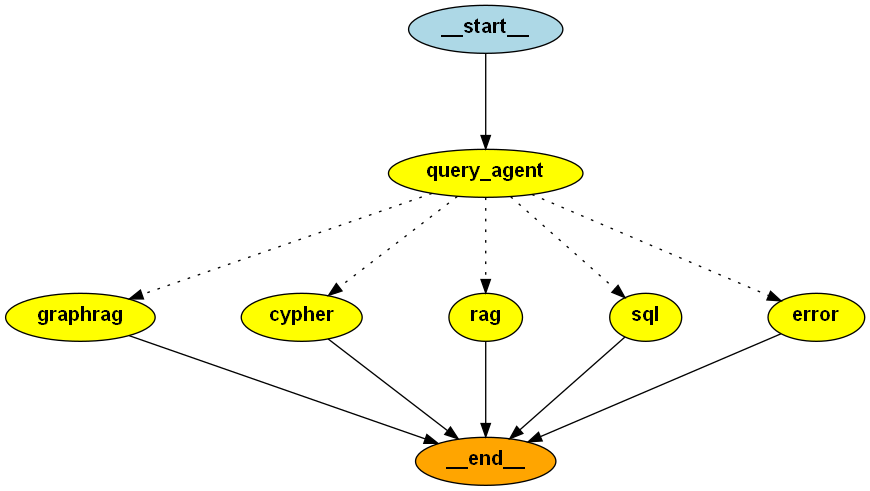

In [197]:
from IPython.display import Image

Image(runnable.get_graph().draw_png())

In [200]:
out = runnable.invoke({"input": "Tell me about consort and rct? `session_id` is abc123"})

> run_query_agent


Parent run 4d0d859a-e870-4989-be9b-e22686981e0c not found for run 0d195d26-5713-4233-8e1a-d0b8324ff7d9. Treating as a root run.


> router
> execute_search


In [177]:
out = runnable.invoke({"input": "How many papers published in 2024? do not use LIMIT. use sql. `session_id` is abc123"})

> run_query_agent
> router
> execute_sql


In [108]:
out = runnable.invoke({"input": "How many papers published in 2024? use cypher. `session_id` is abc123"})

> run_query_agent
> router
> execute_cypher_query


> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (t:Title)-[:PUBLISHED_IN]->(y:Year)
    WHERE y.value = 2024
RETURN COUNT(t)
Full Context:
[{'COUNT(t)': 35}]

> Finished chain.


In [127]:
out = runnable.invoke({"input": "Tell me more. `session_id` is abc123"})

> run_query_agent


Parent run 1d9c8e83-1bdd-458e-ba2a-87f31784be88 not found for run fc687759-a8ee-40d6-ac7d-03e44aea8c81. Treating as a root run.


> router
> execute_embedding_search


In [201]:
out["agent_out"]

{'input': 'consort and rct based on the papers published in 2021',
 'chat_history': [HumanMessage(content='rct'),
  AIMessage(content='A Randomized Controlled Trial (RCT) is a type of scientific experiment that aims to reduce certain types of bias when testing the effectiveness of new treatments. This is achieved by randomly allocating participants to either the group receiving the treatment under investigation or to a group receiving standard treatment (or placebo treatment) as the control. Here are some key points about RCTs based on the provided context:\n\n1. **Definition and Importance**:\n   - RCTs are considered the gold standard for evaluating new therapies or treatment strategies in medicine.\n   - They are crucial for providing valid clinical evidence for medical practitioners, other investigators, and policy makers.\n\n2. **Quality and Reporting**:\n   - The quality of RCT reporting is essential to ensure the validity and reliability of the trial results.\n   - Tools like th